<a href="https://colab.research.google.com/github/chrism-sa/Skripsi---Logistic-Regression/blob/main/Skenario_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
spark = SparkSession.builder.appName("Classification Malware in Network Traffic Use Logistic Regression - Charis Skripsi").getOrCreate()

In [3]:
schema = StructType([
    StructField("ts", DoubleType(), True),
    StructField("uid", StringType(), True),
    StructField("id.orig_h", StringType(), True),
    StructField("id.orig_p", IntegerType(), True),
    StructField("id.resp_h", StringType(), True),
    StructField("id.resp_p", IntegerType(), True),
    StructField("proto", StringType(), True),
    StructField("service", StringType(), True),
    StructField("duration", DoubleType(), True),
    StructField("orig_bytes", IntegerType(), True),
    StructField("resp_bytes", IntegerType(), True),
    StructField("conn_state", StringType(), True),
    StructField("local_orig", StringType(), True),
    StructField("local_resp", StringType(), True),
    StructField("missed_bytes", DoubleType(), True),
    StructField("history", StringType(), True),
    StructField("orig_pkts", DoubleType(), True),
    StructField("orig_ip_bytes", DoubleType(), True),
    StructField("resp_pkts", DoubleType(), True),
    StructField("resp_ip_bytes", DoubleType(), True),
    StructField("tunnel_parents", StringType(), True),
    StructField("label", StringType(), True),
    StructField("detailed_label", StringType(), True)
])

**Load Dataset**

In [4]:
# Nama file yang akan digunakan
file_path = "/content/Dataset.csv"

# Cek apakah file sudah ada di penyimpanan Colab
if os.path.exists(file_path):
    print("✅ File ditemukan! Membaca file tanpa upload ulang...")
    df = pd.read_csv(file_path)
else:
    print("⚠ File tidak ditemukan! Silakan unggah file terlebih dahulu.")

    # Menggunakan fitur upload file di Colab
    from google.colab import files
    uploaded = files.upload()

    # Ambil nama file yang diunggah
    uploaded_file_name = list(uploaded.keys())[0]
    df = pd.read_csv(uploaded_file_name)

    # Simpan file yang telah dibaca agar bisa digunakan tanpa upload ulang
    df.to_csv(file_path, index=False)
    print(f"\n✅ File telah disimpan sebagai '{file_path}'.")


⚠ File tidak ditemukan! Silakan unggah file terlebih dahulu.


Saving DATA PEMODELAN LOGISTIC REGRESSION.csv to DATA PEMODELAN LOGISTIC REGRESSION.csv

✅ File telah disimpan sebagai '/content/Dataset.csv'.


In [5]:
%%time
df = spark.read.csv("/content/Dataset.csv", header=True, sep=",", schema=schema)

CPU times: user 21.3 ms, sys: 4.03 ms, total: 25.4 ms
Wall time: 3.89 s


In [6]:
df = df.withColumnRenamed("id.orig_h", "id_orig_h") \
       .withColumnRenamed("id.orig_p", "id_orig_p") \
       .withColumnRenamed("id.resp_h", "id_resp_h") \
       .withColumnRenamed("id.resp_p", "id_resp_p")

In [7]:
df.limit(12).toPandas().iloc[2:12]

,ts,uid,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label
2,1.545433e+09,CvOvGB2WOKVl6Lo3Wf,192.168.1.195,123,147.231.100.5,123,udp,-,0.001482,48.0,...,-,0.0,Dd,1.0,76.0,1.0,76.0,-,Benign,-
3,1.538583e+09,C44hHm17HZ3lMqs8Tb,192.168.100.113,123,81.2.254.224,123,udp,-,NaN,NaN,...,-,0.0,D,1.0,76.0,0.0,0.0,-,Benign,-
4,1.538573e+09,CFDwDE15VacFXqJUZ4,192.168.100.113,123,144.48.166.166,123,udp,-,NaN,NaN,...,-,0.0,D,1.0,76.0,0.0,0.0,-,Benign,-
5,1.545467e+09,CmYYN04wo2sCcLG5Wk,192.168.1.195,65279,123.59.209.185,80,tcp,-,NaN,NaN,...,-,0.0,C,0.0,0.0,0.0,0.0,-,Malicious,None
6,1.545467e+09,CxNRRwNJhn2pAKXP1,192.168.1.195,65279,123.59.209.185,80,tcp,-,NaN,NaN,...,-,0.0,C,0.0,0.0,0.0,0.0,-,Malicious,None
7,1.538614e+09,CcnxnK3X0qaNCFIFfj,192.168.100.113,123,5.1.56.123,123,udp,-,NaN,NaN,...,-,0.0,D,1.0,76.0,0.0,0.0,-,Benign,-
8,1.538614e+09,CHi0073vh0QyWm6v11,192.168.100.113,39665,192.168.100.1,53,udp,dns,0.000496,45.0,...,-,0.0,Dd,1.0,73.0,1.0,73.0,-,Benign,-
9,1.538603e+09,CrBy6k3Q58tC2vCBw5,192.168.100.113,123,147.231.100.5,123,udp,-,NaN,NaN,...,-,0.0,D,1.0,76.0,0.0,0.0,-,Benign,-
10,1.545467e+09,CoJGGr4w7i74b72Mp1,192.168.1.195,65279,123.59.209.185,80,tcp,-,NaN,NaN,...,-,0.0,C,0.0,0.0,0.0,0.0,-,Malicious,None
11,1.538573e+09,Ch6x1t3sIrR4U8fvR1,192.168.100.113,55077,192.168.100.1,53,udp,dns,5.005400,78.0,...,-,0.0,D,2.0,134.0,0.0,0.0,-,Benign,-


**Preprocessing Data**

**Seleksi Fitur**

In [8]:
# Mengecek jumlah nilai NULL di setiap kolom
null_values = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Mengecek jumlah nilai "-" di setiap kolom
dash_values = df.select([F.sum((F.col(c) == "-").cast("int")).alias(c) for c in df.columns])

# Gabungkan hasil pengecekan null dan "-" ke dalam satu DataFrame Pandas
null_df = null_values.toPandas().T.rename(columns={0: "Number of Null Values"})
dash_df = dash_values.toPandas().T.rename(columns={0: "Number of '-' Values"})

# Gabung kedua hasil menjadi satu tabel untuk kemudahan analisis
result_df = null_df.join(dash_df)
result_df.columns.name = "Column Name"

# Tampilkan hasil
print(result_df)

Column Name     Number of Null Values  Number of '-' Values
ts                                  0                   NaN
uid                                 0                   0.0
id_orig_h                           0                   0.0
id_orig_p                           0                   NaN
id_resp_h                           0                   0.0
id_resp_p                           0                   NaN
proto                               0                   0.0
service                             0                7871.0
duration                         6210                   NaN
orig_bytes                       6210                   NaN
resp_bytes                       6210                   NaN
conn_state                          0                   0.0
local_orig                          0               10390.0
local_resp                          0               10390.0
missed_bytes                        0                   NaN
history                             0   

In [9]:
cols_to_drop = ["uid", "id_orig_h", "id_orig_p", "id_resp_h", "id_resp_p", "service",
                "duration", "orig_bytes", "resp_bytes", "local_orig", "local_resp",
                "history", "tunnel_parents", "detailed_label"]
df = df.drop(*cols_to_drop)
df.limit(12).toPandas().iloc[2:12]

,ts,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
2,1.545433e+09,udp,SF,0.0,1.0,76.0,1.0,76.0,Benign
3,1.538583e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign
4,1.538573e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign
5,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious
6,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious
7,1.538614e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign
8,1.538614e+09,udp,SF,0.0,1.0,73.0,1.0,73.0,Benign
9,1.538603e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign
10,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious
11,1.538573e+09,udp,S0,0.0,2.0,134.0,0.0,0.0,Benign


In [10]:
# Mengecek jumlah nilai NULL di setiap kolom
null_values = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Mengecek jumlah nilai "-" di setiap kolom
dash_values = df.select([F.sum((F.col(c) == "-").cast("int")).alias(c) for c in df.columns])

# Gabungkan hasil pengecekan null dan "-" ke dalam satu DataFrame Pandas
null_df = null_values.toPandas().T.rename(columns={0: "Number of Null Values"})
dash_df = dash_values.toPandas().T.rename(columns={0: "Number of '-' Values"})

# Gabung kedua hasil menjadi satu tabel untuk kemudahan analisis
result_df = null_df.join(dash_df)
result_df.columns.name = "Column Name"

# Tampilkan hasil
print(result_df)

Column Name    Number of Null Values  Number of '-' Values
ts                                 0                   NaN
proto                              0                   0.0
conn_state                         0                   0.0
missed_bytes                       0                   NaN
orig_pkts                          0                   NaN
orig_ip_bytes                      0                   NaN
resp_pkts                          0                   NaN
resp_ip_bytes                      0                   NaN
label                              0                   0.0


**Encoding Fitur**

In [11]:
indexer = StringIndexer(inputCols=["proto", "conn_state"],
                        outputCols=["proto_indexed", "conn_state_indexed"],
                        handleInvalid="keep")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)

In [12]:
proto_labels = indexer_model.labelsArray[0]
conn_labels = indexer_model.labelsArray[1]

print("Mapping kategori 'proto' ke index:")
for i, label in enumerate(proto_labels):
    print(f"{label} = {i}")

print("\n\nMapping kategori 'conn_state' ke index:")
for i, label in enumerate(conn_labels):
    print(f"{label} = {i}")

Mapping kategori 'proto' ke index:
tcp = 0
udp = 1
icmp = 2


Mapping kategori 'conn_state' ke index:
S0 = 0
OTH = 1
SF = 2
S3 = 3
RSTR = 4
S2 = 5


In [13]:
df.limit(12).toPandas().iloc[2:12]

,ts,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_indexed,conn_state_indexed
2,1.545433e+09,udp,SF,0.0,1.0,76.0,1.0,76.0,Benign,1.0,2.0
3,1.538583e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0
4,1.538573e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0
5,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0
6,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0
7,1.538614e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0
8,1.538614e+09,udp,SF,0.0,1.0,73.0,1.0,73.0,Benign,1.0,2.0
9,1.538603e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0
10,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0
11,1.538573e+09,udp,S0,0.0,2.0,134.0,0.0,0.0,Benign,1.0,0.0


In [14]:
oh_encoder = OneHotEncoder(inputCols=["proto_indexed", "conn_state_indexed"],
                           outputCols=["proto_oh_encoded", "conn_state_oh_encoded"])
oh_encoder_model = oh_encoder.fit(df)
df = oh_encoder_model.transform(df)

In [15]:
label_indexer = StringIndexer(inputCol="label", outputCol="encoded_label")
label_indexer_model = label_indexer.fit(df)
df = label_indexer_model.transform(df)

In [16]:
df.limit(12).toPandas().iloc[2:12]

,ts,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_indexed,conn_state_indexed,proto_oh_encoded,conn_state_oh_encoded,encoded_label
2,1.545433e+09,udp,SF,0.0,1.0,76.0,1.0,76.0,Benign,1.0,2.0,"(0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0
3,1.538583e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
4,1.538573e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
5,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",1.0
6,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",1.0
7,1.538614e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
8,1.538614e+09,udp,SF,0.0,1.0,73.0,1.0,73.0,Benign,1.0,2.0,"(0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)",0.0
9,1.538603e+09,udp,S0,0.0,1.0,76.0,0.0,0.0,Benign,1.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
10,1.545467e+09,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious,0.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)",1.0
11,1.538573e+09,udp,S0,0.0,2.0,134.0,0.0,0.0,Benign,1.0,0.0,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0


**Vektorisasi**

In [17]:
X_cols = [col for col in df.columns if col not in ["label", "encoded_label", "proto", "proto_indexed", "conn_state", "conn_state_indexed"]]
vector_assembler = VectorAssembler(inputCols=X_cols, outputCol="feature_vector")
df = vector_assembler.transform(df)

**Normalisasi**

In [18]:
normalizer = MinMaxScaler(inputCol="feature_vector", outputCol="normalized_feature_vector")
normalizer = normalizer.fit(df)
df = normalizer.transform(df)

In [19]:
df.select("feature_vector", "normalized_feature_vector").limit(12).toPandas().iloc[2:12]

,feature_vector,normalized_feature_vector
2,"(1545433108.456638, 0.0, 1.0, 76.0, 1.0, 76.0,...","(0.9917451351542612, 0.0, 0.000169635284139100..."
3,"(1538582545.658519, 0.0, 1.0, 76.0, 0.0, 0.0, ...","(0.0013866695488011737, 0.0, 0.000169635284139..."
4,"(1538573455.664419, 0.0, 1.0, 76.0, 0.0, 0.0, ...","(7.256545624349914e-05, 0.0, 0.000169635284139..."
5,"(1545466964.126317, 0.0, 0.0, 0.0, 0.0, 0.0, 1...","(0.9966395139174883, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,"(1545466984.133378, 0.0, 0.0, 0.0, 0.0, 0.0, 1...","(0.9966424062582815, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,"(1538613756.676788, 0.0, 1.0, 76.0, 0.0, 0.0, ...","(0.005898721634714338, 0.0, 0.0001696352841391..."
8,"(1538613675.676472, 0.0, 1.0, 73.0, 1.0, 73.0,...","(0.005887011742961941, 0.0, 0.0001696352841391..."
9,"(1538602919.668338, 0.0, 1.0, 76.0, 0.0, 0.0, ...","(0.004332058664589728, 0.0, 0.0001696352841391..."
10,"(1545466977.969652, 0.0, 0.0, 0.0, 0.0, 0.0, 1...","(0.9966415151930517, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,"(1538573274.744539, 0.0, 2.0, 134.0, 0.0, 0.0,...","(4.641059277480936e-05, 0.0, 0.000339270568278..."


**Split Data 80:20**

In [20]:
train, test = df.randomSplit([0.8, 0.2], seed=42)

In [21]:
# Hitung jumlah data
train_count = train.count()
test_count = test.count()

# Tampilkan hasil
print(f"Jumlah data untuk training : {train_count}")
print(f"Jumlah data untuk testing  : {test_count}")
print(f"Total data                 : {train_count + test_count}")

Jumlah data untuk training : 8385
Jumlah data untuk testing  : 2005
Total data                 : 10390


In [22]:
# Fungsi Softmax
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Fungsi Cost (Cross-Entropy Loss)
def compute_cost(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

# Fungsi LR
def predict(X, W, b):
    z = np.dot(X, W) + b
    return softmax(z)

# Fungsi Gradient Descent untuk update parameter
def gradient_descent(X_train, y_train_true, X_test, y_test_true, W, b, alpha, epochs):
    m = X_train.shape[0]
    cost_history = []
    train_acc_history = []
    test_acc_history = []

    for i in range(epochs):
        # Forward pass (prediksi)
        y_train_pred = predict(X_train, W, b)
        y_test_pred = predict(X_test, W, b)

        # Gradien dari W dan b
        dW = np.dot(X_train.T, (y_train_pred - y_train_true)) / m
        db = np.sum(y_train_pred - y_train_true, axis=0) / m

        # Update parameter
        W -= alpha * dW
        b -= alpha * db

        # Hitung cost dan akurasi
        cost = compute_cost(y_train_true, y_train_pred)
        cost_history.append(cost)

        # Konversi prediksi ke label (argmax)
        y_train_pred_labels = np.argmax(y_train_pred, axis=1)
        y_test_pred_labels = np.argmax(y_test_pred, axis=1)

        y_train_true_labels = np.argmax(y_train_true, axis=1)
        y_test_true_labels = np.argmax(y_test_true, axis=1)

        # Hitung akurasi
        train_acc = np.mean(y_train_pred_labels == y_train_true_labels)
        test_acc = np.mean(y_test_pred_labels == y_test_true_labels)

        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

    return W, b, cost_history, train_acc_history, test_acc_history

In [23]:
# Konversi fitur dan label menjadi NumPy array
X_train = np.array(train.select("normalized_feature_vector").rdd.map(lambda x: x[0]).collect())
y_train = np.array(train.select("encoded_label").rdd.map(lambda x: x[0]).collect())

X_test = np.array(test.select("normalized_feature_vector").rdd.map(lambda x: x[0]).collect())
y_test = np.array(test.select("encoded_label").rdd.map(lambda x: x[0]).collect())

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

# Inisialisasi data
X = X_train
y = y_train.astype(int)

# Menyimpan hasil setiap fold
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_index, val_index in kf.split(X):
    # Split data untuk fold ini
    X_tr, X_val = X[train_index], X[val_index]
    y_tr, y_val = y[train_index], y[val_index]

    # One-hot encoding untuk label training & validasi
    n_classes = len(np.unique(y))
    y_tr_one_hot = np.zeros((y_tr.shape[0], n_classes))
    y_tr_one_hot[np.arange(y_tr.shape[0]), y_tr] = 1
    y_val_one_hot = np.zeros((y_val.shape[0], n_classes))
    y_val_one_hot[np.arange(y_val.shape[0]), y_val] = 1

    # Inisialisasi bobot dan bias
    np.random.seed(42)
    W = np.random.rand(X_tr.shape[1], n_classes)
    b = np.zeros((1, n_classes))

    learning_rate = 0.1
    epochs = 21

    # Training model
    W, b, cost_history, train_acc_history, test_acc_history = gradient_descent(
        X_tr, y_tr_one_hot, X_val, y_val_one_hot, W, b, learning_rate, epochs
    )

    # Prediksi pada data validasi
    y_val_pred = predict(X_val, W, b)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)

    # Hitung metrik evaluasi
    acc = accuracy_score(y_val, y_val_pred_labels)
    prec = precision_score(y_val, y_val_pred_labels, average='weighted', zero_division=0)
    rec = recall_score(y_val, y_val_pred_labels, average='weighted')
    f1 = f1_score(y_val, y_val_pred_labels, average='weighted')

    # Simpan hasil ke list
    results.append({
        "Fold ke-": fold,
        "Akurasi": round(acc * 100, 2),
        "Presisi": round(prec * 100, 2),
        "Recall": round(rec * 100, 2),
        "F1-Score": round(f1 * 100, 2)
    })

    fold += 1

# Buat DataFrame hasil
results_df = pd.DataFrame(results)

# Tambah baris rata-rata
mean_row = {
    "Fold ke-": "Rata-rata",
    "Akurasi": round(results_df["Akurasi"].mean(), 2),
    "Presisi": round(results_df["Presisi"].mean(), 2),
    "Recall": round(results_df["Recall"].mean(), 2),
    "F1-Score": round(results_df["F1-Score"].mean(), 2)
}
results_df.loc[len(results_df)] = mean_row

# Tampilkan tabel hasil
print("\n📊 Tabel Hasil 5-Fold Cross Validation:")
print(results_df.to_string(index=False))


📊 Tabel Hasil 5-Fold Cross Validation:
 Fold ke-  Akurasi  Presisi  Recall  F1-Score
        1    98.81    98.84   98.81     98.81
        2    98.57    98.61   98.57     98.57
        3    99.05    99.06   99.05     99.05
        4    99.34    99.35   99.34     99.34
        5    98.57    98.60   98.57     98.57
Rata-rata    98.87    98.89   98.87     98.87


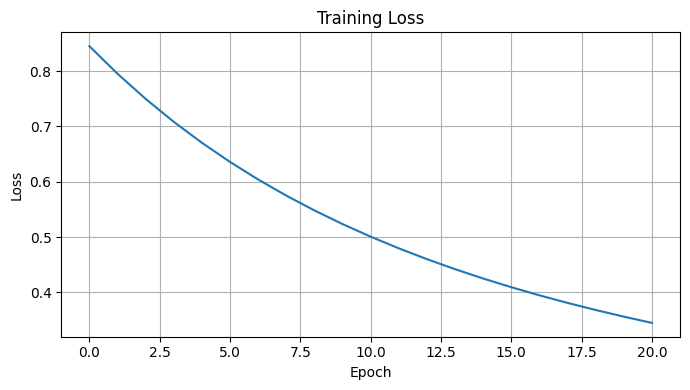

In [25]:
plt.figure(figsize=(7,4))
plt.plot(cost_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

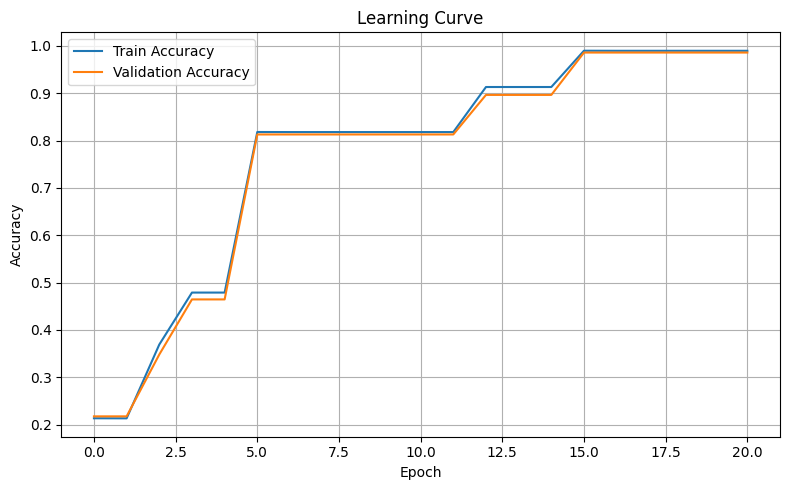

In [26]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

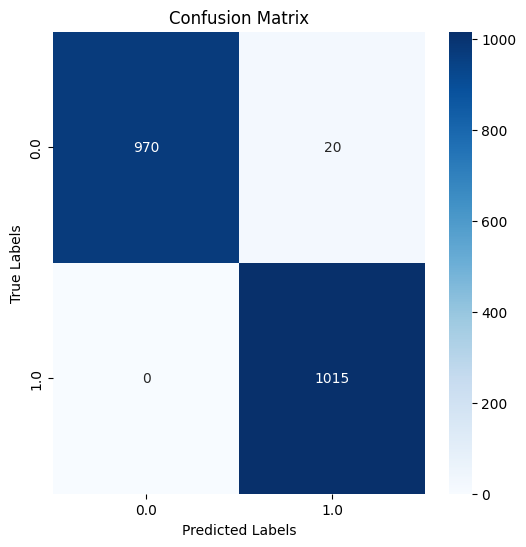

In [27]:
y_test_pred = predict(X_test, W, b)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_test_pred_labels)

# Menampilkan confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



Classification Report:

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       990
         1.0       0.98      1.00      0.99      1015

    accuracy                           0.99      2005
   macro avg       0.99      0.99      0.99      2005
weighted avg       0.99      0.99      0.99      2005



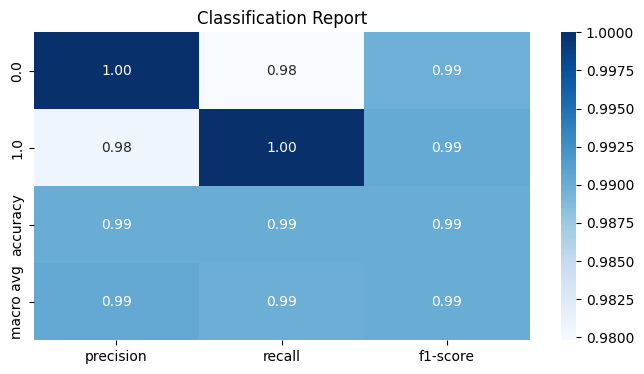

In [28]:
# Print classification report yang mencakup precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred_labels, target_names=[str(i) for i in np.unique(y_test)]))

classification_report(y_test, y_test_pred_labels, digits=3)
report = classification_report(y_test,y_test_pred_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report")
plt.show()

In [29]:
label_dist = pd.DataFrame(y_test, columns=["Label"]).value_counts().reset_index(name='Count')
print(label_dist)

   Label  Count
0    1.0   1015
1    0.0    990


In [30]:
# Menampilkan mapping dari encoded label ke label asli
label_mapping = list(enumerate(label_indexer_model.labels))
label_df = pd.DataFrame(label_mapping, columns=["Encoded Label", "Original Label"])
print(label_df)

   Encoded Label Original Label
0              0         Benign
1              1      Malicious


In [31]:
pip install gradio

In [32]:
import gradio as gr
import pandas as pd
import numpy as np

# Mapping label (misal: 0 = Benign, 1 = Malicious)
label_map = {i: label for i, label in enumerate(label_indexer_model.labels)}

def classify_csv(file):
    try:
        status_text = "⏳ Memproses data... Mohon tunggu sebentar."

        # 1. Baca dan siapkan data
        df_pd = pd.read_csv(file.name)
        df_pd = df_pd.replace('-', 0)

        cols_to_drop = ["uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p",
                        "local_orig", "local_resp", "service", "history", "tunnel_parents",
                        "detailed-label"]
        df_pd.drop(columns=[col for col in cols_to_drop if col in df_pd.columns], inplace=True)

        df_pd["proto"] = df_pd["proto"].astype(str)
        df_pd["conn_state"] = df_pd["conn_state"].astype(str)
        df_pd["label"] = df_pd["label"].astype(str)

        # 2. Transformasi data
        df_new = spark.createDataFrame(df_pd)
        df_new = indexer_model.transform(df_new)
        df_new = oh_encoder_model.transform(df_new)
        df_new = vector_assembler.transform(df_new)
        df_new = normalizer.transform(df_new)

        # 3. Prediksi
        X_new = np.array(df_new.select("normalized_feature_vector").rdd.map(lambda x: x[0]).collect())
        y_pred = predict(X_new, W, b)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # 4. Ambil label asli dan hitung akurasi
        label_cleaned = df_pd["label"].str.lower().str.strip()
        label_inverse_map = {v.lower(): k for k, v in label_map.items()}
        y_true = label_cleaned.map(lambda x: label_inverse_map.get(x, -1)).values

        if len(y_true) != len(y_pred_labels) or -1 in y_true:
            accuracy = "⚠️ Label asli tidak lengkap/valid untuk perhitungan akurasi."
        else:
            acc = np.mean(y_true == y_pred_labels)
            accuracy = f"🎯 Akurasi model: {acc*100:.2f}%"

        # 5. Format hasil
        hasil = []
        for i, label_id in enumerate(y_pred_labels):
            label_name = label_map.get(label_id, str(label_id))
            status = "⚠️ Waspada (Malicious)" if "malicious" in label_name.lower() else "✅ Aman (Benign)"
            hasil.append(f"Data ke-{i+1}: {label_name} → {status}")

        scrollable_output = f"""
        <div style="height:400px; overflow-y:scroll; border:1px solid #ccc; padding:10px; background:#000000; color:white;">
        {'<br>'.join(hasil)}
        </div>
        <p style="color:lime; font-weight:bold;">{accuracy}</p>
        """

        return "✅ Proses Selesai!, 🔍 Silahkan Cek Data Anda", scrollable_output

    except Exception as e:
        return f"❌ Terjadi error: {str(e)}", ""

# Interface Gradio
demo = gr.Interface(
    fn=classify_csv,
    inputs=gr.File(label="📄 Upload File CSV"),
    outputs=[
        gr.Textbox(label="📢 Status Proses", interactive=False),
        gr.HTML(label="📋 Hasil Klasifikasi (Scrollable)")
    ],
    title="🔍 Malware Detector Application",
    description="Charis Maulana Setya Adi - 210605110083"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da7b8d940425f148e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
from pyspark.sql import SparkSession

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("TampilkanDataAwalAkhir").getOrCreate()

# Baca data CSV
df = spark.read.option("header", True).option("inferSchema", True).csv("DATA PEMODELAN LOGISTIC REGRESSION.csv")

# Hitung total jumlah baris
total_rows = df.count()

# Tampilkan 50 data pertama
print("=== 50 Data Pertama ===")
df.limit(50).toPandas().iloc[0:50]



=== 50 Data Pertama ===


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545475e+09,C6bHu52sHY5ZG1UUIb,192.168.1.195,123,195.113.144.201,123,udp,-,-,-,...,-,0,D,1,76,0,0,-,Benign,-
1,1.538601e+09,CFCGvp4aEVGId8CkPh,192.168.100.113,53292,192.168.100.1,53,udp,dns,5.005152,78,...,-,0,D,2,134,0,0,-,Benign,-
2,1.545433e+09,CvOvGB2WOKVl6Lo3Wf,192.168.1.195,123,147.231.100.5,123,udp,-,0.001482,48,...,-,0,Dd,1,76,1,76,-,Benign,-
3,1.538583e+09,C44hHm17HZ3lMqs8Tb,192.168.100.113,123,81.2.254.224,123,udp,-,-,-,...,-,0,D,1,76,0,0,-,Benign,-
4,1.538573e+09,CFDwDE15VacFXqJUZ4,192.168.100.113,123,144.48.166.166,123,udp,-,-,-,...,-,0,D,1,76,0,0,-,Benign,-
5,1.545467e+09,CmYYN04wo2sCcLG5Wk,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
6,1.545467e+09,CxNRRwNJhn2pAKXP1,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
7,1.538614e+09,CcnxnK3X0qaNCFIFfj,192.168.100.113,123,5.1.56.123,123,udp,-,-,-,...,-,0,D,1,76,0,0,-,Benign,-
8,1.538614e+09,CHi0073vh0QyWm6v11,192.168.100.113,39665,192.168.100.1,53,udp,dns,0.000496,45,...,-,0,Dd,1,73,1,73,-,Benign,-
9,1.538603e+09,CrBy6k3Q58tC2vCBw5,192.168.100.113,123,147.231.100.5,123,udp,-,-,-,...,-,0,D,1,76,0,0,-,Benign,-


In [34]:
# Tampilkan 50 data terakhir
print("\n=== 50 Data Terakhir ===")
df.limit(10390).toPandas().iloc[10340:10390]



=== 50 Data Terakhir ===


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
10340,1.545414e+09,CxeuUi44Tr4atSTtGh,192.168.1.195,51630,185.244.25.235,6667,tcp,-,-,-,...,-,0,S,1,60,0,0,-,Malicious,None
10341,1.545418e+09,CvnqKT3SKjLqYr4Daj,192.168.1.195,53158,185.244.25.235,6667,tcp,-,-,-,...,-,0,S,1,60,0,0,-,Malicious,None
10342,1.545405e+09,CjhrbhqQGvjXCYZX4,192.168.1.195,49090,185.244.25.235,6667,tcp,-,3.103981,0,...,-,0,S,3,180,0,0,-,Malicious,None
10343,1.545431e+09,C3rIlE48h7tkeOZZe9,192.168.1.195,123,147.231.100.5,123,udp,-,0.001497,48,...,-,0,Dd,1,76,1,76,-,Benign,-
10344,1.545467e+09,CdBykh4RfpYwP9zEwb,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
10345,1.545411e+09,CIJvcL2gkSbCRyP9Yh,192.168.1.195,51020,185.244.25.235,6667,tcp,irc,4.089921,75,...,-,0,ShAdDaf,9,567,6,563,-,Malicious,None
10346,1.545416e+09,CEVVidnUULWC2TVrk,192.168.1.195,52422,185.244.25.235,6667,tcp,-,3.089493,0,...,-,0,S,3,180,0,0,-,Malicious,None
10347,1.545467e+09,CGD5Bv3Ul0QwXo9qO2,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
10348,1.545467e+09,CTilp13j0ivhgEkhh6,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
10349,1.545467e+09,C0ycR7l2rUEfNVgCh,192.168.1.195,65279,123.59.209.185,80,tcp,-,-,-,...,-,0,C,0,0,0,0,-,Malicious,None
